In [2]:
import ezdxf

In [3]:
ezdxf.__version__

'1.1.4'

In [14]:
dxf_path = '/aistudio/workspace/aigc_ssd/liyulong/project/frame_gpt/living_space/test/res/bx.dxf'
dxf_path = '/aistudio/workspace/aigc_ssd/liyulong/project/frame_gpt/living_space/test/res/fs.dxf'
dxf_path = '/aistudio/workspace/aigc_ssd/liyulong/project/frame_gpt/living_space/test/res/B2.dxf'
dxf_path = '/aistudio/workspace/aigc_ssd/liyulong/project/frame_gpt/living_space/test/res/small.dxf'
dxf_path = '/aistudio/workspace/aigc_ssd/liyulong/project/frame_gpt/living_space/test/res/layer.dxf'
dxf_path = '/aistudio/workspace/aigc_ssd/liyulong/project/frame_gpt/living_space/test/res/simple_item.dxf'
doc = ezdxf.readfile(dxf_path)

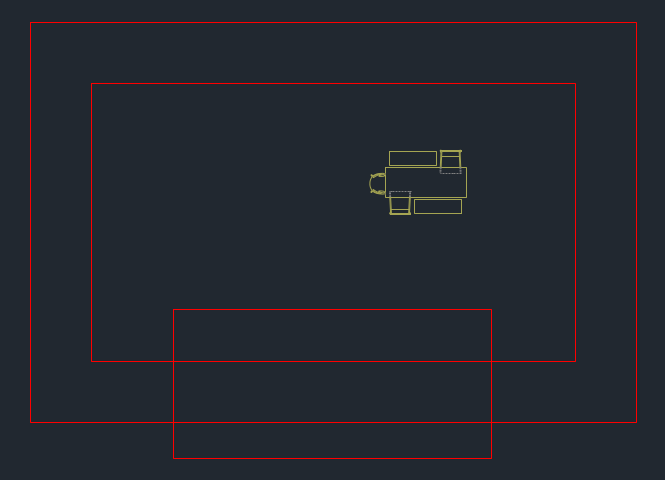

In [15]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

import ezdxf
from ezdxf.math import Matrix44
from ezdxf.addons.drawing import RenderContext, Frontend
from ezdxf.addons.drawing.matplotlib import MatplotlibBackend

def get_wcs_to_image_transform(
    ax: plt.Axes, image_size: tuple[int, int]
) -> Matrix44:
    """Returns the transformation matrix from modelspace coordinates to image
    coordinates.
    """

    x1, x2 = ax.get_xlim()
    y1, y2 = ax.get_ylim()
    data_width, data_height = x2 - x1, y2 - y1
    image_width, image_height = image_size
    return (
        Matrix44.translate(-x1, -y1, 0)
        @ Matrix44.scale(
            image_width / data_width, -image_height / data_height, 1.0
        )
        # +1 to counteract the effect of the pixels being flipped in y
        @ Matrix44.translate(0, image_height + 1, 0)
    )

# create the DXF document
# doc = ezdxf.new()
# msp = doc.modelspace()
# msp.add_lwpolyline([(0, 0), (1, 0), (1, 1), (0, 1)], close=True)
# msp.add_line((0, 0), (1, 1))
msp = doc.modelspace()

# export the pixel image
fig: plt.Figure = plt.figure()
ax: plt.Axes = fig.add_axes([0, 0, 1, 1])
ctx = RenderContext(doc)
out = MatplotlibBackend(ax)
Frontend(ctx, out).draw_layout(msp, finalize=True)
fig.savefig("cad.png")
plt.close(fig)

# reload the pixel image by Pillow (PIL)
img = Image.open("cad.png")
draw = ImageDraw.Draw(img)

# add some annotations to the pixel image by using modelspace coordinates
m = get_wcs_to_image_transform(ax, img.size)
a, b, c = (
    (v.x, v.y)  # draw.line() expects tuple[float, float] as coordinates
    # transform modelspace coordinates to image coordinates
    for v in m.transform_vertices([(0.25, 0.75), (0.75, 0.25), (1, 1)])
)
draw.line([a, b, c, a], fill=(255, 0, 0))

# show the image by the default image viewer
img.show()

In [8]:
print(list(doc.layers))

# # iteration
# for layer in doc.layers:
#     print(layer.dxf.name)
#     if layer.dxf.name != "墙体":
#         print('off', layer.dxf.name)
#         layer.off()  # switch all layers off except layer "0"

# # check for existing layer definition
# if "MyLines" in doc.layers:
#     layer = doc.layers.get("MyLines")

# layer_count = len(doc.layers) # total count of layer definitions
# layer_count

[<class 'ezdxf.entities.layer.Layer'> LAYER(#6), <class 'ezdxf.entities.layer.Layer'> LAYER(#A8), <class 'ezdxf.entities.layer.Layer'> LAYER(#54), <class 'ezdxf.entities.layer.Layer'> LAYER(#74), <class 'ezdxf.entities.layer.Layer'> LAYER(#A5), <class 'ezdxf.entities.layer.Layer'> LAYER(#D0), <class 'ezdxf.entities.layer.Layer'> LAYER(#AD), <class 'ezdxf.entities.layer.Layer'> LAYER(#C5), <class 'ezdxf.entities.layer.Layer'> LAYER(#B3), <class 'ezdxf.entities.layer.Layer'> LAYER(#111)]


In [9]:
from ezdxf.addons.drawing import Frontend, RenderContext, svg, layout, config
def export(doc):
    msp = doc.modelspace()
    # 1. create the render context
    context = RenderContext(doc)
    # 2. create the backend
    backend = svg.SVGBackend()
    # 3. create the frontend
    frontend = Frontend(context, backend)
    # 4. draw the modelspace
    frontend.draw_layout(msp)
    # 5. create an A4 page layout, not required for all backends
    page = layout.Page(210, 297, layout.Units.mm, margins=layout.Margins.all(20))
    # 6. get the SVG rendering as string - this step is backend dependent
    svg_string = backend.get_string(page)
    with open("output.svg", "wt", encoding="utf8") as fp:
        fp.write(svg_string)

In [11]:
export(doc)

In [23]:
from ezdxf.addons.drawing import Frontend, RenderContext, pymupdf, layout, config
def export_dark_bg(doc):
    msp = doc.modelspace()
    # 1. create the render context
    context = RenderContext(doc)
    # 2. create the backend
    backend = pymupdf.PyMuPdfBackend()
    # 3. create the frontend
    frontend = Frontend(context, backend)
    # 4. draw the modelspace
    frontend.draw_layout(msp)
    # 5. create an A4 page layout
    page = layout.Page(210, 297, layout.Units.mm, margins=layout.Margins.all(20))
    # 6. get the PDF rendering as bytes
    # pdf_bytes = backend.get_pdf_bytes(page)
    # with open("pdf_dark_bg.pdf", "wb") as fp:
    #     fp.write(pdf_bytes)
    png_bytes = backend.get_pixmap_bytes(page, fmt="png", dpi=96)
    with open("png_white_bg.png", "wb") as fp:
        fp.write(png_bytes)

In [46]:
# export_dark_bg(doc)